In [53]:
import requests
import pandas as pd
import pmdarima as pm
from matplotlib import pyplot as plt

PROMETHEUS = "http://prometheus.chess.example"
query = """
  (sum(
  node_namespace_pod_container:container_cpu_usage_seconds_total:sum_irate{namespace="default"}
  * on(namespace,pod)
  group_left(workload, workload_type) namespace_workload_pod:kube_pod_owner:relabel{namespace="default", workload_type="deployment", workload="engine-service"})
  by (workload, workload_type)
  )[5m:1s]
"""
query2 = 'sum (rate (container_cpu_usage_seconds_total{container="engine-service"}[80s]))[20m:5s]'
req = requests.get(PROMETHEUS + "/api/v1/query", params={"query": query2})
json = req.json()

data = pd.DataFrame(json["data"]["result"][0]["values"], columns = ['time','value'])
data['time'] = pd.to_datetime(data['time'], unit='s', origin='unix')
data['value'] = pd.to_numeric(data['value'])
#data = data.set_index('time')

print(req.url)

http://prometheus.chess.example/api/v1/query?query=sum+%28rate+%28container_cpu_usage_seconds_total%7Bcontainer%3D%22engine-service%22%7D%5B80s%5D%29%29%5B20m%3A5s%5D


In [55]:
from statsmodels.tsa.arima.model import ARIMA
n_periods = 20

arima = pm.auto_arima(data.value[:-n_periods], start_p=1, start_q=1,
                         test='adf',
                         max_p=2, max_q=2, m=20,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         #error_action='ignore',  
                         #suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[20] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(0,0,0)(0,1,0)[20] intercept   : AIC=155.835, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[20] intercept   : AIC=62.959, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[20] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,0,0)(0,1,0)[20]             : AIC=153.932, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[20] intercept   : AIC=124.180, Time=0.07 sec
 ARIMA(1,0,0)(2,1,0)[20] intercept   : AIC=24.896, Time=1.97 sec
 ARIMA(1,0,0)(2,1,1)[20] intercept   : AIC=17.653, Time=5.64 sec
 ARIMA(1,0,0)(1,1,1)[20] intercept   : AIC=inf, Time=1.52 sec
 ARIMA(1,0,0)(2,1,2)[20] intercept   : AIC=18.584, Time=9.73 sec
 ARIMA(1,0,0)(1,1,2)[20] intercept   : AIC=inf, Time=12.86 sec
 ARIMA(0,0,0)(2,1,1)[20] intercept   : AIC=42.824, Time=6.26 sec
 ARIMA(2,0,0)(2,1,1)[20] intercept   : AIC=19.592, Time=12.12 sec
 ARIMA(1,0,1)(2,1,1)[20] intercept   : AIC=19.610, Time=10.41 sec
 ARIMA(0,0,1)(2,1,1)[20] intercept   : AIC=21.999, Ti

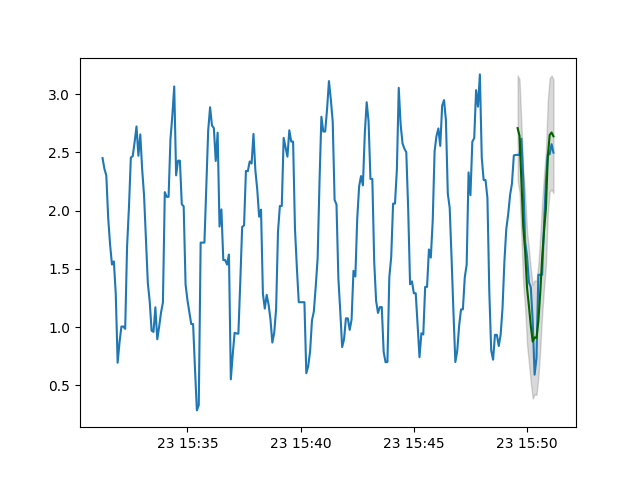

In [56]:
%matplotlib widget
fc, confint = arima.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = data.time[-n_periods:]

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data.time, data.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
n_periods = 20
my_order = (1, 0, 0)
my_seasonal_order = (2, 1, 1, 20)

model = SARIMAX(data.value[:-n_periods], order=my_order, seasonal_order=my_seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit()
model.summary()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.70454D-02    |proj g|=  1.02880D+00


 This problem is unconstrained.



At iterate    5    f= -1.16466D-02    |proj g|=  4.50459D-02

At iterate   10    f= -1.73054D-02    |proj g|=  1.28650D-02

At iterate   15    f= -1.73450D-02    |proj g|=  1.36929D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     20      1     0     0   2.164D-06  -1.735D-02
  F =  -1.7345030056900707E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  220
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 20)   Log Likelihood                   3.816
Date:                              Sun, 23 Jan 2022   AIC                              2.368
Time:                                      16:57:24   BIC                             17.713
Sample:                                           0   HQIC                             8.599
                                              - 220                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3894      0.074      5.241      0.000       0.244       0.535
ar.S.L20      -0.6089      0.099     -6.174      0.000      -0.802      -0.416
ar.S.L40      -0.3777      0.076     -4.939      0.000      -0.528      -0.228
ma.S.L20      -0.3154      0.140     -2.260      0.024      -0.589      -0.042
sigma2         0.0551      0.007      8.209      0.000       0.042       0.068
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.80
Prob(Q):                              0.99   Prob(JB):                         0.67
Heteroskedasticity (H):               0.84   Skew:                             0.17
Prob(H) (two-sided):                  0.52   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

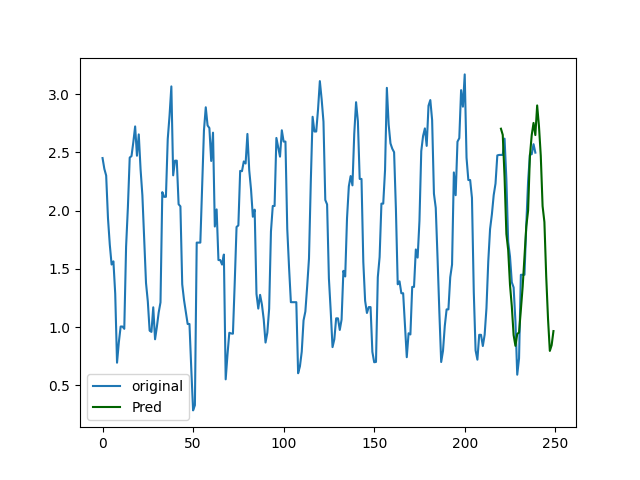

In [61]:
%matplotlib widget
fc = model.forecast(30)

# Plot
ox = [i for i in range(0,len(data.value))]

plt.plot(ox, data.value, label="original")
px = [i for i in range(len(data.value)-n_periods, len(data.value)-n_periods+len(fc))]

plt.plot(px, fc, color='darkgreen', label="Pred")
plt.legend()

In [57]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  220
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 20)   Log Likelihood                  -2.949
Date:                              Sun, 23 Jan 2022   AIC                             15.897
Time:                                      16:56:49   BIC                             32.389
Sample:                                           0   HQIC                            22.571
                                              - 220                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3723      0.059      6.324      0.000       0.257       0.488
ar.S.L20      -0.3271      0.126     -2.588      0.010      -0.575      -0.079
ar.S.L40      -0.2234      0.090     -2.478      0.013      -0.400      -0.047
ma.S.L20      -0.6175      0.124     -4.980      0.000      -0.860      -0.374
sigma2         0.0536      0.006      8.963      0.000       0.042       0.065
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.06
Prob(Q):                              0.91   Prob(JB):                         0.22
Heteroskedasticity (H):               0.80   Skew:                             0.30
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""